In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apachemirror.wuchna.com/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop2.7.tgz
!tar xf spark-3.0.0-preview2-bin-hadoop2.7.tgz
!pip install -q findspark


In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
from google.colab import files
uploaded = files.upload()

Saving PastHires.csv to PastHires.csv


In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml').getOrCreate()
df = spark.read.csv('PastHires.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- Years Experience: integer (nullable = true)
 |-- Employed?: string (nullable = true)
 |-- Previous employers: integer (nullable = true)
 |-- Level of Education: string (nullable = true)
 |-- Top-tier school: string (nullable = true)
 |-- Interned: string (nullable = true)
 |-- Hired: string (nullable = true)



In [0]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
Years Experience,10,0,7,2,20
Employed?,Y,N,N,Y,N
Previous employers,4,0,6,1,2
Level of Education,BS,BS,BS,MS,PhD
Top-tier school,N,Y,N,Y,Y
Interned,N,Y,N,N,N
Hired,Y,Y,N,Y,N


In [0]:
dff = pd.read_csv("PastHires.csv")
dff.head(10)

,Years Experience,Employed?,Previous employers,Level of Education,Top-tier school,Interned,Hired
0,10,Y,4,BS,N,N,Y
1,0,N,0,BS,Y,Y,Y
2,7,N,6,BS,N,N,N
3,2,Y,1,MS,Y,N,Y
4,20,N,2,PhD,Y,N,N
5,0,N,0,PhD,Y,Y,Y
6,5,Y,2,MS,N,Y,Y
7,3,N,1,BS,N,Y,Y
8,15,Y,5,BS,N,N,Y
9,0,N,0,BS,N,N,N


In [0]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
Years Experience,10,0,7,2,20
Employed?,Y,N,N,Y,N
Previous employers,4,0,6,1,2
Level of Education,BS,BS,BS,MS,PhD
Top-tier school,N,Y,N,Y,Y
Interned,N,Y,N,N,N
Hired,Y,Y,N,Y,N


In [0]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Years Experience,13,5.153846153846154,6.3488339329118,0,20
Previous employers,13,1.7692307692307692,2.006400016357911,0,6


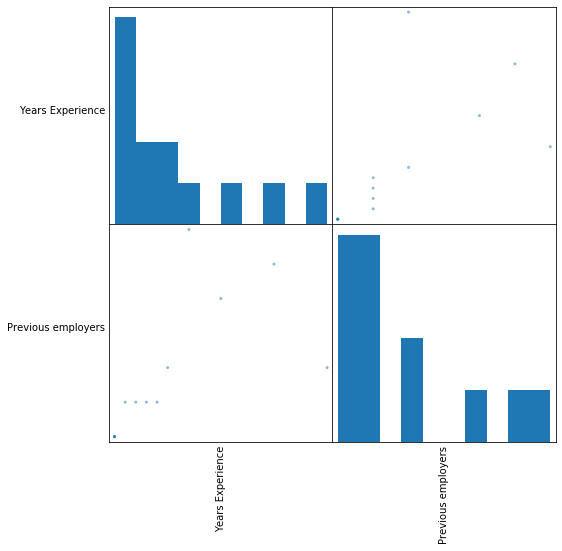

In [0]:
#from pandas.plotting import scatter_matrix
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [0]:
from pyspark.ml.feature import OneHotEncoder,OneHotEncoderEstimator, StringIndexer, VectorAssembler

categoricalColumns = ['Employed?', 'Level of Education', 'Top-tier school', 'Interned', 'Hired']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(dropLast=False, inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    model = encoder.fit(df)
    encoded = model.transform(df)
    stages += [stringIndexer, encoder]
    #stages += [stringIndexer, encoded]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['Years Experience', 'Previous employers']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

ImportError: ignored

In [0]:
cols = df.columns

In [0]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

AnalysisException: ignored

In [0]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
Years Experience,10,0,7,2,20
Employed?,Y,N,N,Y,N
Previous employers,4,0,6,1,2
Level of Education,BS,BS,BS,MS,PhD
Top-tier school,N,Y,N,Y,Y
Interned,N,Y,N,N,N
Hired,Y,Y,N,Y,N


In [0]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 9
Test Dataset Count: 4


In [0]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

IllegalArgumentException: ignored